## Efficient Influence Function (EIF) & Continuous Treatment with DML

Daniel de Abreu Pereira Uhr




**Observações:** O material apresentado aqui é uma adaptação do material de aula do Prof. Daniel de Abreu Pereira Uhr, e não deve ser utilizado para fins comerciais. O material é disponibilizado para fins educacionais e de pesquisa, e não deve ser reproduzido sem a devida autorização do autor. Este material pode conter erros e imprecisões. O autor não se responsabiliza por quaisquer danos ou prejuízos decorrentes do uso deste material. O uso deste material é de responsabilidade exclusiva do usuário. Caso você encontre erros ou imprecisões neste material, por favor, entre em contato com o autor para que possam ser corrigidos. O autor agradece qualquer *feedback* ou sugestão de melhoria.

---

### Efficient Influence Function (EIF)


A **Efficient Influence Function (EIF)** (ou **Função de Influência Eficiente**) é o **objeto matemático fundamental** que define:

1. o **estimador mais eficiente possível** de um parâmetro causal (como o ATE),
2. e as condições sob as quais esse estimador é **sem viés em primeira ordem** mesmo quando usamos ML flexível nas etapas auxiliares.

Quando queremos estimar um parâmetro causal, por exemplo o efeito médio do tratamento (ATE):

$$
\psi_0 = E[m_1(X) - m_0(X)]
$$

onde ($m_d(X) = E[Y|D=d, X]$),

temos duas fontes de incerteza:

* o erro de amostragem (ruído estatístico);
* e o erro de estimação dos “nuisance functions” (os modelos de ($E[Y|D,X]$) e ($P(D|X)$)).


**Definição**

A **Efficient Influence Function (EIF)** é uma função ($\phi(W; \psi_0)$) que mede **como o erro em cada observação influencia o erro total do estimador** de forma linearizada.

Considere o espaço de todas as distribuições ($P$) para os dados ($W=(Y,D,X)$). O parâmetro de interesse é uma função ($\psi(P)$) (por exemplo, o ATE).

A **influence function** (IF) é definida como:

$$
\phi(W; P) = \left. \frac{d}{d\epsilon} \psi(P_\epsilon) \right|_{\epsilon=0}
$$

onde ($P_\epsilon = (1 - \epsilon) P + \epsilon \delta_W$).

***Interpretação:***

É a **sensibilidade infinitesimal** do estimando ($\psi(P)$) a pequenas perturbações na distribuição amostral em torno de ($P$).

A **Efficient Influence Function (EIF)** é a **influence function com menor variância** entre todas as IFs válidas (isto é, todas que têm esperança zero e derivam corretamente ($\psi(P)$)).
Essa variância mínima define o **semiparametric efficiency bound**.

**Exemplo**

Para ($D \in {0,1}$), o EIF do ATE é:

$$
\phi(W; \eta) =
\left[
\frac{D}{p(X)} - \frac{1-D}{1-p(X)}
\right](Y - m(D,X)) + [m(1,X) - m(0,X)] - \psi
$$

onde:

* ($p(X) = P(D=1|X)$) é o propensity score,
* ($m(d,X) = E[Y|D=d, X]$) é o outcome regression,
* ($\eta = (m, p)$) é o vetor dos “nuisance parameters”.

Esse objeto é importante porque:

* ($E[\phi(W; \eta_0)] = 0$) no ponto verdadeiro;
* Ele é **ortogonal**: pequenas variações em ($m$) ou ($p$) não alteram ($\psi$) em primeira ordem;
* E ele **gera todos os estimadores eficientes** possíveis (TMLE, AIPW, DR-DML, etc).

A EIF serve como a **base de construção** de todos os estimadores modernos de efeito causal:

| Estimador                | Como usa a EIF                                                            |
| ------------------------ | ------------------------------------------------------------------------- |
| **AIPW (Augmented IPW)** | Substitui ($m, p$) por ML e usa a média de ($\phi(W; \hat\eta)$)              |
| **TMLE**                 | Ajusta ($m$) até que a média de ($\phi(W; \hat\eta^*) = 0$)                   |
| **DR-DML**               | Usa cross-fitting e estima ($\psi$) resolvendo ($E_n[\phi(W; \hat\eta)] = 0$) |
| **Causal Forests**       | Aproximam o EIF localmente em cada folha                                  |
| **G-formula**            | Implícita, sem ajuste pela EIF (por isso é menos robusta)                 |


***Propriedades***

1. **Esperança zero:**
   $$
   E[\phi(W; \eta_0)] = 0
   $$

2. **Ortogonalidade:**
   $$
   \frac{\partial E[\phi(W; \eta)]}{\partial \eta}\Big|_{\eta_0} = 0
   $$
   → pequenos erros em ML não afetam ($\hat\psi$).

3. **Variância mínima:**
   $$
   Var(\phi(W; \eta_0)) = \text{Semiparametric Efficiency Bound}
   $$

4. **Inferência assintótica:**
   $$
   \sqrt{n}(\hat\psi - \psi_0) \to N(0, Var(\phi(W; \eta_0)))
   $$
   → Intervalos de confiança vêm diretamente da EIF.

***Relação entre TMLE, DR e DML***

* **TMLE**: constrói um modelo para ($m(D,X)$) e ajusta via *targeting* até satisfazer ($E_n[\phi(W;\hat\eta)] = 0$).
* **DR-DML**: usa cross-fitting e resolve a mesma equação, mas sem targeting iterativo.
* **Ambos estimam o mesmo parâmetro** — o ATE — definido exatamente pela EIF acima.


***Interpretação intuitiva***

Pense na EIF como o **"peso ótimo"** que cada observação deve ter para corrigir viés de confusão.

* O termo ($\frac{D}{p(X)} - \frac{1-D}{1-p(X)}$) ajusta o desequilíbrio de propensão;
* O termo ($Y - m(D,X)$) corrige a predição;
* E ($m(1,X) - m(0,X)$) dá o componente contrafactual esperado.

A média ponderada desses componentes é o **efeito causal eficiente**.

### Continuous Treatment with DML



In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns

# DataFrame
df = pd.read_stata("https://github.com/Daniel-Uhr/data/raw/main/cattaneo2.dta")

In [8]:
# Criar a variável de resultado
df['Y'] = df['bweight']

# Crie a variável 'Treated' com valor inicial de 0
df['Treated'] = 0
# Recodifique 'Treated' para 1 se 'mbsmoke' for igual a 'smoker'
df.loc[df['mbsmoke'] == 'smoker', 'Treated'] = 1

df['casada'] = 0
df.loc[df['mmarried']=='married', 'casada'] = 1

# Conjunto de Covariáveis X
X = ['casada', 'mage', 'medu']

# garanta a ordem correta das categorias (se necessário)
order = ['0 daily', '1-5 daily', '6-10 daily', '11+ daily']
df['msmoke'] = pd.Categorical(df['msmoke'], categories=order, ordered=True)

# mapeamentos
map_mid = {
    '0 daily': 0,
    '1-5 daily': 3,
    '6-10 daily': 8,
    '11+ daily': 12  # ajuste se quiser um outro representativo (ex.: 15)
}
map_ord = {k: i for i, k in enumerate(order)}  # 0,1,2,3 (ordinal)

# variáveis de tratamento
df['T_cont'] = df['msmoke'].map(map_mid).astype(float) 

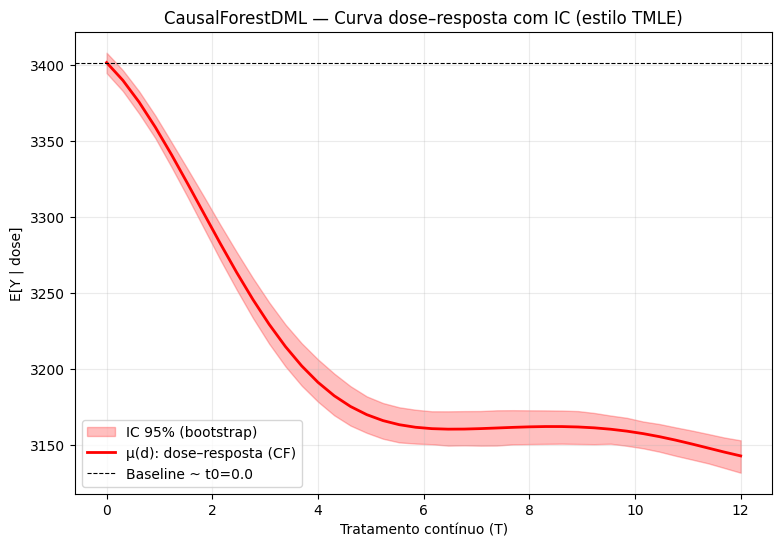

In [32]:
# ==========================================================
# CausalForestDML — Dose–resposta com IC (vermelho), "estilo TMLE"
# Nível = E[Y|t0,X] (modelo de outcome) + efeito CF (t0->t)
# Grid de 40 pts; RBF features ricas; bootstrap nas unidades X
# ==========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import make_pipeline
from sklearn.base import clone
from econml.dml import CausalForestDML

# ---------- Config ----------
RNG_SEED = 42
rng = np.random.default_rng(RNG_SEED)

# ---------- 0) Dados ----------
try:
    df
except NameError:
    df = pd.read_stata("https://github.com/Daniel-Uhr/data/raw/main/cattaneo2.dta")
    df['Y'] = df['bweight']
    df['casada'] = (df['mmarried'] == 'married').astype(int)

# Use o T_cont contínuo que você já criou (sem jitter), ou crie mapeamento midpoints
# Aqui assumo que df['T_cont'] já existe (se não, crie como no seu TMLE).
df_ = df[['Y','T_cont','casada','mage','medu']].dropna().copy()

Y = df_['Y'].to_numpy(dtype=np.float32)
T = df_['T_cont'].to_numpy(dtype=np.float32)
X = df_[['casada','mage','medu']].to_numpy(dtype=np.float32)

Xn = StandardScaler().fit_transform(X).astype(np.float32)

# ---------- 1) Featurizador em T: RBF (mais rico → curva menos "quadrática") ----------
tfeat = RBFSampler(gamma=0.08, n_components=150, random_state=RNG_SEED)

# ---------- 2) Nuisance models (um pouco mais fortes, ainda rápidos) ----------
rf_cfg = dict(
    n_estimators=120,
    max_depth=10,
    min_samples_leaf=15,
    max_features='sqrt',
    n_jobs=-1,
    random_state=RNG_SEED
)
model_y = ExtraTreesRegressor(**rf_cfg)
model_t = ExtraTreesRegressor(**rf_cfg)

# ---------- 3) CausalForestDML ----------
cf = CausalForestDML(
    model_y=model_y,
    model_t=model_t,
    treatment_featurizer=tfeat,
    discrete_treatment=False,
    n_estimators=300,
    min_samples_leaf=10,
    max_depth=8,
    random_state=RNG_SEED,
    n_jobs=-1,
    verbose=0
)
# T em 2D por causa do featurizer
cf.fit(Y, T.reshape(-1, 1), X=Xn)

# ---------- 4) Modelo de outcome para o NÍVEL E[Y|t0, X]
# Usamos a MESMA featurização de T do CF para coerência
# Feature final: concatena Xn com phi(T) (RBF transform)
Phi_T = tfeat.fit_transform(T.reshape(-1, 1))  # usa a mesma instância tfeat
Z = np.hstack([Xn, Phi_T])                     # regressão Y ~ X + phi(T)

outcome_model = clone(model_y)
outcome_model.fit(Z, Y)

def predict_y_at_t(Xblock, t_scalar):
    # constroi features [X, phi(t)] p/ cada linha de Xblock
    m = Xblock.shape[0]
    Phi = tfeat.transform(np.full((m, 1), t_scalar, dtype=np.float32))
    Zt = np.hstack([Xblock, Phi])
    return outcome_model.predict(Zt)

# ---------- 5) Curva dose–resposta + IC (bootstrap nas unidades X)
# amostra maior de X para agregação
M = min(600, len(Xn))
idx = rng.choice(len(Xn), size=M, replace=False)
Xsub = Xn[idx]

# grid de 40 doses
t_min, t_max = float(np.nanmin(T)), float(np.nanmax(T))
G = 40
t_grid = np.linspace(t_min, t_max, G).astype(np.float32)

# baseline: percentil 5% (na região com dados)
t0 = float(np.percentile(T, 5))

# 5.1) Nível no baseline por unidade: Y_hat(t0|X)
y0_hat = predict_y_at_t(Xsub, t0)  # (M,)

# 5.2) Efeito marginal CF por unidade para cada t do grid
Eff = np.empty((G, M), dtype=np.float32)
for g, t1 in enumerate(t_grid):
    T0 = np.full((M, 1), t0, dtype=np.float32)
    T1 = np.full((M, 1), t1, dtype=np.float32)
    Eff[g, :] = cf.effect(Xsub, T0=T0, T1=T1)  # τ(X; t0→t1)

# 5.3) Reconstrução do nível e média por dose
# μ(d) = mean_X [ Y_hat(t0|X) + τ(X; t0→d) ]
mu_hat = (y0_hat[None, :] + Eff).mean(axis=1)  # (G,)

# 5.4) Bootstrap das unidades X (rápido, sem refitar o CF)
B = 300
boot_mu = np.empty((B, G), dtype=np.float32)
for b in range(B):
    samp = rng.integers(0, M, size=M)  # reamostra unidades
    boot_mu[b, :] = (y0_hat[samp][None, :] + Eff[:, samp]).mean(axis=1)

alpha = 0.05
lo = np.percentile(boot_mu, 100*(alpha/2), axis=0)
hi = np.percentile(boot_mu, 100*(1-alpha/2), axis=0)

# ---------- 6) Plot (vermelho) ----------
plt.figure(figsize=(9,6))
plt.fill_between(t_grid, lo, hi, color='red', alpha=0.25, label='IC 95% (bootstrap)')
plt.plot(t_grid, mu_hat, color='red', lw=2, label='μ(d): dose–resposta (CF)')
plt.axhline(mu_hat[np.argmin(np.abs(t_grid - t0))], color='k', ls='--', lw=0.8, label=f'Baseline ~ t0={t0:.1f}')
plt.xlabel("Tratamento contínuo (T)")
plt.ylabel("E[Y | dose]")
plt.title("CausalForestDML — Curva dose–resposta com IC (estilo TMLE)")
plt.legend()
plt.grid(True, alpha=0.25)
plt.show()


c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\econml-env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\econml-env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


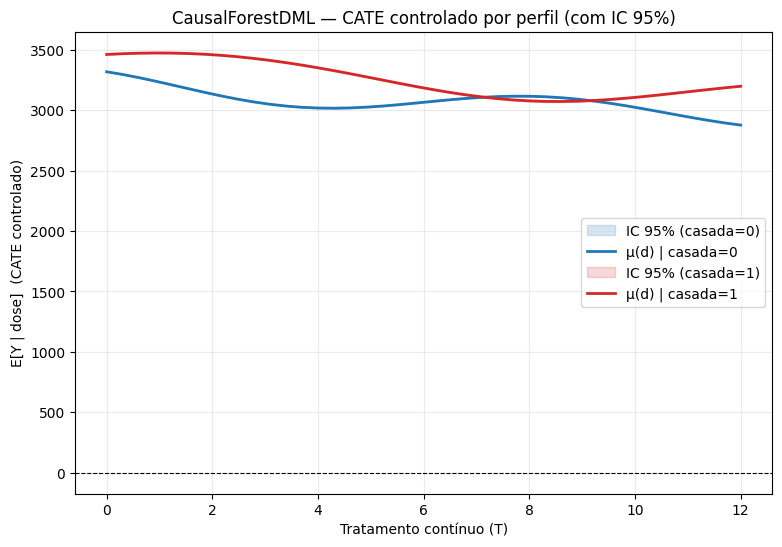

In [ ]:
# ==========================================================
# CATE controlado (por perfil) — CF + baseline outcome
# Você define como "controlar" cada covariável (mean/median/pXX/valor)
# ==========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# ----------------------------------------------------------
# 0) PRÉ-REQUISITOS (já existentes no seu fluxo anterior)
# ----------------------------------------------------------
# - df_: DataFrame usado no fit, com colunas ['casada','mage','medu', ...]
# - COLS_X: ordem das covariáveis em X (ex.: ['casada','mage','medu'])
# - scaler: StandardScaler já ajustado em df_[COLS_X]
# - cf: CausalForestDML já treinado com treatment_featurizer=tfeat
# - tfeat: mesmo featurizador de T usado no cf (RBF/Spline)
# - outcome_model: modelo de outcome treinado em [Xn, phi(T)]
# - T, t_grid (40 pts), t0 já definidos

# Se ainda não tiver o scaler salvo, refaça aqui (mesmo padrão do treino):
# scaler = StandardScaler().fit(df_[COLS_X].astype(float))

# ----------------------------------------------------------
# 1) Helpers para "especificações de controle"
# ----------------------------------------------------------
def _resolve_control_value(series: pd.Series, spec):
    """
    Converte um especificador (string ou número) em valor numérico.
      - 'mean' -> média
      - 'median' -> mediana
      - 'pXX' -> percentil XX (ex.: 'p10','p25','p90')
      - numérico -> retorna como float
    """
    if isinstance(spec, (int, float, np.number)):
        return float(spec)
    if isinstance(spec, str):
        s = spec.strip().lower()
        if s == "mean":
            return float(series.mean())
        if s == "median":
            return float(series.median())
        if s.startswith("p"):
            try:
                q = float(s[1:])
                return float(np.percentile(series.to_numpy(dtype=float), q))
            except Exception:
                raise ValueError(f"Percentil inválido em '{spec}'. Use 'p10','p50','p90', etc.")
    raise ValueError(f"Especificação de controle inválida: {spec}")

def make_controlled_profile(df_base: pd.DataFrame, cols_x, control_spec: dict):
    """
    Gera um dicionário {col: valor_controlado} para TODAS as colunas em cols_x.
    - control_spec pode ter:
        * chave ausente -> usa 'mean' por padrão
        * valor string ('mean','median','p90',...) ou número
    """
    prof = {}
    for c in cols_x:
        spec = control_spec.get(c, "mean")  # default: média
        prof[c] = _resolve_control_value(df_base[c], spec)
    return prof

def to_vec(profile: dict, cols_x):
    """Converte dict -> vetor 2D (1,d) na ordem de cols_x."""
    return np.array([profile[c] for c in cols_x], dtype=np.float32).reshape(1, -1)

# ----------------------------------------------------------
# 2) Predição de nível no baseline (reusa outcome_model e tfeat)
# ----------------------------------------------------------
def predict_y_at_t(Xblock_scaled, t_scalar):
    m = Xblock_scaled.shape[0]
    Tmat = np.full((m, 1), t_scalar, dtype=np.float32)
    Phi  = tfeat.transform(Tmat)
    Zt   = np.hstack([Xblock_scaled, Phi])
    return outcome_model.predict(Zt)

# ----------------------------------------------------------
# 3) CATE controlado de um perfil (com IC por bootstrap)
# ----------------------------------------------------------
def cate_controlled_curve(cf, scaler, profile_dict, cols_x, t_grid, t0,
                          B=300, M=600, jitter=None, alpha=0.05, rng_seed=42):
    """
    Retorna (mu_hat, lo, hi) para um perfil CONTROLADO:
      - profile_dict: dict com valores fixos para TODAS as covariáveis em cols_x.
      - jitter: dict opcional ex.: {'mage': 1.5, 'medu': 1.0} (desvio-padrão do ruído normal)
                Útil para reduzir variância (marginalização local leve). Binárias NÃO recebem jitter.
      - M: nº de "clones" do perfil para agregação rápida
      - B: nº de bootstraps sobre esses clones
    """
    rng = np.random.default_rng(rng_seed)

    # 3.1) Monta base X do perfil (M clones)
    x0 = to_vec(profile_dict, cols_x)              # (1,d)
    X0 = np.repeat(x0, repeats=M, axis=0)         # (M,d)

    # 3.2) Jitter opcional para contínuas (mantém binárias intactas)
    if jitter:
        for jcol, sd in jitter.items():
            if jcol in cols_x and sd and sd > 0:
                j_idx = cols_x.index(jcol)
                # adiciona ruído gaussiano APENAS nas contínuas
                X0[:, j_idx] = X0[:, j_idx] + rng.normal(0.0, sd, size=M).astype(np.float32)

    # 3.3) Padroniza igual ao treino
    X0s = scaler.transform(X0.astype(float).copy())

    # 3.4) Nível no baseline: E[Y|t0, X]
    y0_hat = predict_y_at_t(X0s, t0)  # (M,)

    # 3.5) Efeitos CF (τ) no grid
    G = len(t_grid)
    Eff = np.empty((G, M), dtype=np.float32)
    for g, t1 in enumerate(t_grid):
        T0 = np.full((M, 1), t0, dtype=np.float32)
        T1 = np.full((M, 1), t1, dtype=np.float32)
        Eff[g, :] = cf.effect(X0s, T0=T0, T1=T1)

    # 3.6) Curva em nível e IC bootstrap (re-amostrando clones)
    mu_hat = (y0_hat[None, :] + Eff).mean(axis=1)  # (G,)
    boot_mu = np.empty((B, G), dtype=np.float32)
    for b in range(B):
        samp = rng.integers(0, M, size=M)
        boot_mu[b, :] = (y0_hat[samp][None, :] + Eff[:, samp]).mean(axis=1)

    lo = np.percentile(boot_mu, 100*(alpha/2), axis=0)
    hi = np.percentile(boot_mu, 100*(1-alpha/2), axis=0)
    return mu_hat, lo, hi

# ----------------------------------------------------------
# 4) DEFINA AQUI suas “regras de controle”
#    - o que muda entre perfis (heterogeneidade) e
#    - como controlar o restante (mean/median/pXX ou valor)
# ----------------------------------------------------------
# Exemplo: estudar heterogeneidade em 'casada'
#          mantendo mage e medu em 'mean' (poderia ser 'median' ou números)
CONTROL_SPEC_BASE = {
    'casada': 'mean',   # será sobrescrito no perfil A/B
    'mage':   'mean',   # pode ser 'median', 'p25', 'p75', ou valor numérico
    'medu':   'mean'
}

# Resolve os valores controlados de base (para consultar médias/medianas etc.)
ctrl_base = make_controlled_profile(df_[COLS_X], COLS_X, CONTROL_SPEC_BASE)

# Perfis que mudam APENAS na(s) covariável(is) de interesse:
perfil_A = {**ctrl_base, 'casada': 0}
perfil_B = {**ctrl_base, 'casada': 1}

# ----------------------------------------------------------
# 5) Rode as curvas CATE controladas
# ----------------------------------------------------------
# grid de 40 pontos (se ainda não existia)
if 't_grid' not in globals():
    t_min, t_max = float(np.nanmin(T)), float(np.nanmax(T))
    t_grid = np.linspace(t_min, t_max, 40, dtype=np.float32)
if 't0' not in globals():
    t0 = float(np.percentile(T, 5))

# jitter leve (opcional) para estabilizar (ex.: 0.5 anos em idade e 0.5 em educação)
JITTER = {'mage': 0.5, 'medu': 0.5}  # defina {} para desligar

mu_A, lo_A, hi_A = cate_controlled_curve(cf, scaler, perfil_A, COLS_X, t_grid, t0,
                                         B=300, M=600, jitter=JITTER, alpha=0.05, rng_seed=42)
mu_B, lo_B, hi_B = cate_controlled_curve(cf, scaler, perfil_B, COLS_X, t_grid, t0,
                                         B=300, M=600, jitter=JITTER, alpha=0.05, rng_seed=43)


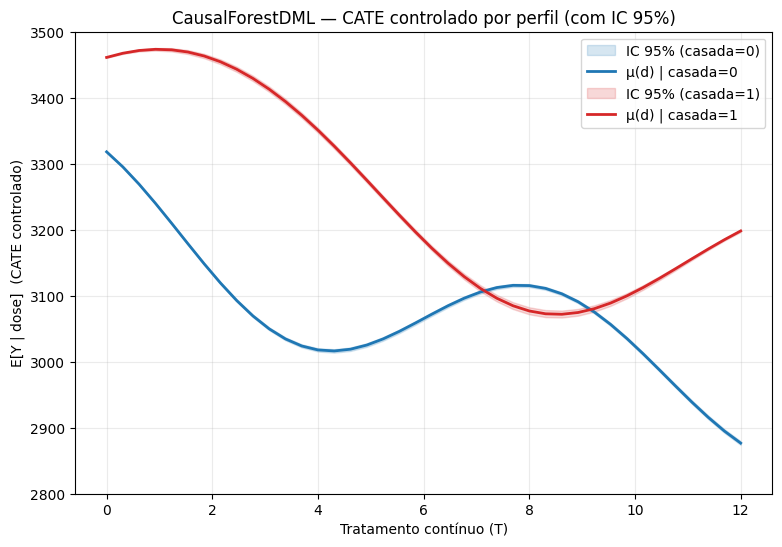

In [44]:
# ----------------------------------------------------------
# 6) Plot final
# ----------------------------------------------------------
plt.figure(figsize=(9,6))
plt.fill_between(t_grid, lo_A, hi_A, color='#1f77b4', alpha=0.18, label='IC 95% (casada=0)')
plt.plot(t_grid, mu_A, color='#1f77b4', lw=2, label='μ(d) | casada=0')

plt.fill_between(t_grid, lo_B, hi_B, color='#d62728', alpha=0.18, label='IC 95% (casada=1)')
plt.plot(t_grid, mu_B, color='#d62728', lw=2, label='μ(d) | casada=1')

plt.axhline(0, color='k', ls='--', lw=0.8)
plt.xlabel("Tratamento contínuo (T)")
plt.ylabel("E[Y | dose]  (CATE controlado)")
plt.title("CausalForestDML — CATE controlado por perfil (com IC 95%)")
plt.ylim(2800, 3500) 
plt.grid(True, alpha=0.25)
plt.legend()
plt.show()

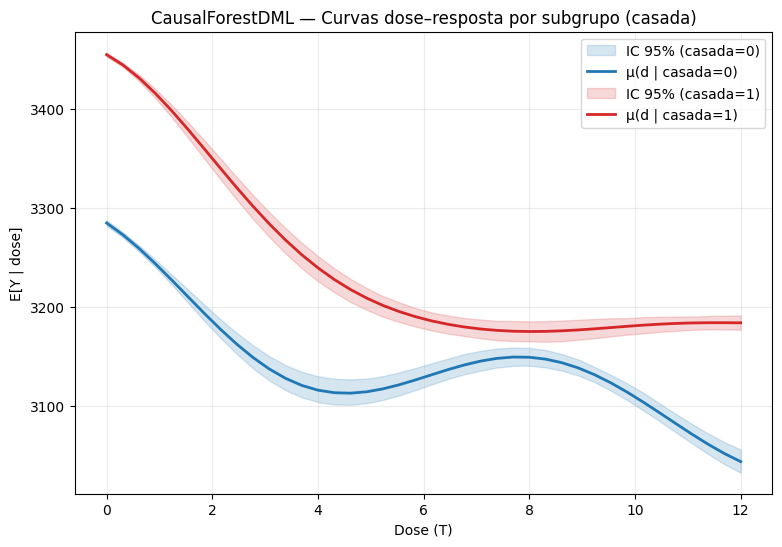

In [33]:
# ==========================================================
# Curvas dose–resposta heterogêneas por subgrupo (casada=0 vs 1)
# Reusa cf, tfeat, outcome_model, Xn, T, t_grid, t0 do bloco anterior
# ==========================================================
B = 300
alpha = 0.05
rng = np.random.default_rng(42)

# Índices de cada grupo conforme df_ usado no fit
g_all = df_['casada'].to_numpy().astype(int)
idx_g0 = np.where(g_all == 0)[0]
idx_g1 = np.where(g_all == 1)[0]

def subgroup_curve(idx_group, label, color, M_target=600):
    # Amostra X do subgrupo (para média rápida)
    M = min(M_target, len(idx_group))
    if M == 0:
        raise ValueError(f"Subgrupo {label} vazio.")
    sub_idx = rng.choice(idx_group, size=M, replace=False)
    Xsub = Xn[sub_idx]

    # Nível no baseline: E[Y|t0, X] com o mesmo outcome_model
    y0_hat = predict_y_at_t(Xsub, t0)  # (M,)

    # Efeitos CF para cada dose do grid
    G = len(t_grid)
    Eff = np.empty((G, M), dtype=np.float32)
    for g, t1 in enumerate(t_grid):
        T0 = np.full((M, 1), t0, dtype=np.float32)
        T1 = np.full((M, 1), t1, dtype=np.float32)
        Eff[g, :] = cf.effect(Xsub, T0=T0, T1=T1)

    # μ(d | grupo) = média_Xsub [ y0_hat + τ(X; t0→d) ]
    mu_hat = (y0_hat[None, :] + Eff).mean(axis=1)

    # Bootstrap nas unidades do grupo
    boot_mu = np.empty((B, G), dtype=np.float32)
    for b in range(B):
        samp = rng.integers(0, M, size=M)  # reamostra colunas
        boot_mu[b, :] = (y0_hat[samp][None, :] + Eff[:, samp]).mean(axis=1)

    lo = np.percentile(boot_mu, 100*(alpha/2), axis=0)
    hi = np.percentile(boot_mu, 100*(1-alpha/2), axis=0)

    # Plot
    plt.fill_between(t_grid, lo, hi, color=color, alpha=0.18, label=f'IC 95% ({label})')
    plt.plot(t_grid, mu_hat, color=color, lw=2, label=f'μ(d | {label})')

# --------- Plot conjunto ---------
plt.figure(figsize=(9,6))
subgroup_curve(idx_g0, label='casada=0', color='#1f77b4')  # azul
subgroup_curve(idx_g1, label='casada=1', color='#d62728')  # vermelho
# baseline visual (opcional): nível médio do grupo casada=0 em t0
# plt.axvline(t0, color='k', ls='--', lw=0.8, label=f't0={t0:.1f}')
plt.xlabel("Dose (T)")
plt.ylabel("E[Y | dose]")
plt.title("CausalForestDML — Curvas dose–resposta por subgrupo (casada)")
plt.grid(True, alpha=0.25)
plt.legend()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- Parâmetros de robustez/velocidade ----------
B_BOOT   = 300        # # de replicações bootstrap (reduza p/ ainda mais rápido)
M_TARGET = 800        # no. máx. de unidades por grupo para a média (cap de memória)
CHUNK    = 400        # processar efeitos em blocos (economiza RAM)
alpha    = 0.05
rng      = np.random.default_rng(123)

# --- índices dos grupos na mesma amostra usada no fit ---
g_all = df_['casada'].to_numpy().astype(int)
idx_g0 = np.where(g_all == 0)[0]
idx_g1 = np.where(g_all == 1)[0]

# --- grid em região de overlap dos grupos (evita extrapolação) ---
def group_grid_overlap(T, idx0, idx1, G=40):
    t0_lo, t0_hi = np.percentile(T[idx0], [2, 98])
    t1_lo, t1_hi = np.percentile(T[idx1], [2, 98])
    lo = max(t0_lo, t1_lo); hi = min(t0_hi, t1_hi)
    if not np.isfinite(lo) or not np.isfinite(hi) or lo >= hi:
        lo, hi = np.percentile(T, [5, 95])
    return np.linspace(float(lo), float(hi), G).astype(np.float32)

t0 = float(np.percentile(T, 5))
t_grid = group_grid_overlap(T, idx_g0, idx_g1, G=40)

# --- função utilitária: baseline por unidade em t_scalar ---
def yhat_at_t(Xblock, t_scalar):
    m = Xblock.shape[0]
    Tt = np.full((m, 1), t_scalar, dtype=np.float32)
    Ph = tfeat.transform(Tt)
    Z  = np.hstack([Xblock, Ph])
    return outcome_model.predict(Z).astype(np.float32)

# --- calcula curva média de um grupo via bootstrap de unidades ---
def group_curve_bootstrap(idx_group, color, label):
    # amostra até M_TARGET unidades do grupo p/ controlar RAM/tempo
    n_full = len(idx_group)
    m = min(M_TARGET, n_full)
    sub_idx = rng.choice(idx_group, size=m, replace=False)
    Xg = Xn[sub_idx]

    # baseline por unidade
    y0_vec = yhat_at_t(Xg, t0)   # (m,)

    # efeitos por unidade e por dose, em blocos CHUNK p/ não estourar memória
    G = len(t_grid)
    Eff = np.empty((G, m), dtype=np.float32)
    for g, t1 in enumerate(t_grid):
        T0m = np.full((m, 1), t0, dtype=np.float32)
        T1m = np.full((m, 1), t1, dtype=np.float32)
        # em blocos:
        out = np.empty(m, dtype=np.float32)
        for s in range(0, m, CHUNK):
            e = min(s+CHUNK, m)
            out[s:e] = cf.effect(Xg[s:e], T0=T0m[s:e], T1=T1m[s:e]).astype(np.float32)
        Eff[g, :] = out

    # média pontual da curva do grupo
    mu_hat = (y0_vec[None, :] + Eff).mean(axis=1)  # (G,)

    # bootstrap nas unidades (barato; não refita nada)
    boot_mu = np.empty((B_BOOT, G), dtype=np.float32)
    for b in range(B_BOOT):
        samp = rng.integers(0, m, size=m)  # reamostra colunas
        boot_mu[b, :] = (y0_vec[samp][None, :] + Eff[:, samp]).mean(axis=1)

    lo = np.percentile(boot_mu, 100*(alpha/2), axis=0)
    hi = np.percentile(boot_mu, 100*(1-alpha/2), axis=0)

    # plot
    plt.fill_between(t_grid, lo, hi, color=color, alpha=0.18, label=f'IC 95% ({label})')
    plt.plot(t_grid, mu_hat, color=color, lw=2, label=f'μ(d | {label})')

# --------- Plot conjunto ---------
plt.figure(figsize=(9,6))
group_curve_bootstrap(idx_g0, color='#1f77b4', label='casada=0')
group_curve_bootstrap(idx_g1, color='#d62728', label='casada=1')
plt.xlabel("Dose (T)")
plt.ylabel("E[Y | dose]")
plt.title("CausalForestDML — Curvas dose–resposta por subgrupo (mem-safe)")
plt.grid(True, alpha=0.25); plt.legend(); plt.show()


In [42]:
import numpy as np
import matplotlib.pyplot as plt

alpha = 0.05

# --- índices dos grupos na mesma amostra usada no fit ---
g_all = df_['casada'].to_numpy().astype(int)
idx_g0 = np.where(g_all == 0)[0]
idx_g1 = np.where(g_all == 1)[0]

# --- grid de doses dentro do suporte de cada grupo (evita extrapolação) ---
def group_grid(T, idx, G=40):
    t_lo, t_hi = np.percentile(T[idx], [2, 98])
    # se o grupo é pequeno/estreito, caia para o global com leve expansão
    if not np.isfinite(t_lo) or not np.isfinite(t_hi) or t_lo >= t_hi:
        t_lo, t_hi = np.percentile(T, [2, 98])
    return np.linspace(float(t_lo), float(t_hi), G).astype(np.float32)

t0 = float(np.percentile(T, 5))      # baseline (fixo)
t_grid0 = group_grid(T, idx_g0, G=40)
t_grid1 = group_grid(T, idx_g1, G=40)
t_grid  = np.linspace(max(t_grid0.min(), t_grid1.min()),
                      min(t_grid0.max(), t_grid1.max()), 40).astype(np.float32)

# --- função: curva média do grupo com IC do CF + baseline em nível ---
def group_curve_with_cf_inference(idx_group, t_grid, t0, alpha=0.05):
    Xg = Xn[idx_group]
    n  = len(Xg)

    # baseline médio do grupo em nível: E[Y|t0, X] com outcome_model
    T0 = np.full((n, 1), t0, dtype=np.float32)
    Phi0 = tfeat.transform(T0)
    Z0   = np.hstack([Xg, Phi0])
    y0_bar = float(np.mean(outcome_model.predict(Z0)))

    mu, lo, hi = [], [], []
    for t1 in t_grid:
        T1 = np.full((n, 1), t1, dtype=np.float32)
        inf = cf.effect_inference(Xg, T0=T0, T1=T1)
        summ = inf.population_summary(alpha=alpha)  # média do efeito e IC da média
        tau_bar = float(summ.mean_point)
        ci_low, ci_high = summ.conf_int_mean

        mu.append(y0_bar + tau_bar)
        lo.append(y0_bar + float(ci_low))
        hi.append(y0_bar + float(ci_high))
    return np.array(mu), np.array(lo), np.array(hi)

mu0, lo0, hi0 = group_curve_with_cf_inference(idx_g0, t_grid, t0, alpha)
mu1, lo1, hi1 = group_curve_with_cf_inference(idx_g1, t_grid, t0, alpha)

plt.figure(figsize=(9,6))
plt.fill_between(t_grid, lo0, hi0, color='#1f77b4', alpha=0.18, label='IC 95% (casada=0)')
plt.plot(t_grid, mu0, color='#1f77b4', lw=2, label='μ(d | casada=0)')

plt.fill_between(t_grid, lo1, hi1, color='#d62728', alpha=0.18, label='IC 95% (casada=1)')
plt.plot(t_grid, mu1, color='#d62728', lw=2, label='μ(d | casada=1)')

plt.xlabel("Dose (T)")
plt.ylabel("E[Y | dose]")
plt.title("CausalForestDML — Curvas dose–resposta por subgrupo (com IC 95%)")
plt.grid(True, alpha=0.25); plt.legend(); plt.show()


MemoryError: Unable to allocate 242. MiB for an array with shape (1394, 22801) and data type float64

c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\econml-env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\econml-env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\econml-env\Lib\site-packages\econml\inference\_inference.py:823: RuntimeWarning: invalid value encountered in divide
  return (self.point_estimate - value) / self.stderr
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\econml-env\Lib\site-packages\econml\inference\_inference.py:823: RuntimeWarning: invalid value encountered in divide
  return (self.point_estimate - value) / self.stderr


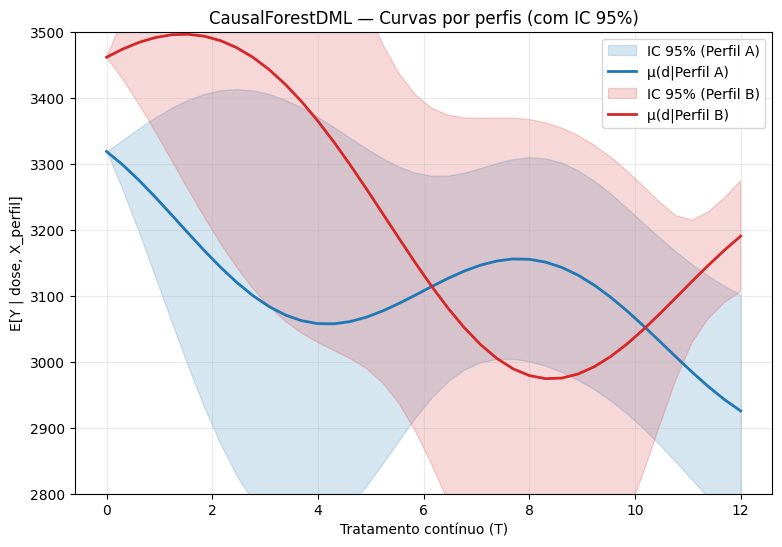

In [41]:
# ===== ICs para curvas por perfil usando effect_inference =====
import numpy as np
import matplotlib.pyplot as plt

# --- (reusa: cf, tfeat, outcome_model, df_, COLS_X, T, t_grid, t0) ---

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(df_[COLS_X].astype(float))

def to_vec(profile, cols):
    return np.array([profile[c] for c in cols], dtype=np.float32).reshape(1, -1)

# Cálculo das médias da amostra
mage_mean = df_['mage'].mean()
medu_mean = df_['medu'].mean()

perfil_A = {'casada': 0, 'mage': mage_mean, 'medu': medu_mean}
perfil_B = {'casada': 1, 'mage': mage_mean, 'medu': medu_mean}
COLS_X   = ['casada','mage','medu']

XA_scaled = scaler.transform(to_vec(perfil_A, COLS_X))
XB_scaled = scaler.transform(to_vec(perfil_B, COLS_X))

t_min, t_max = float(np.nanmin(T)), float(np.nanmax(T))
t_grid = np.linspace(t_min, t_max, 40, dtype=np.float32)
t0 = float(np.percentile(T, 5))

def curve_with_ci_for_profile(X0, t_grid, t0, alpha=0.05):
    # baseline esperado E[Y|t0, X0] com o mesmo modelo de outcome usado no treino
    T0 = np.full((1, 1), t0, dtype=np.float32)
    Phi0 = tfeat.transform(T0)
    Z0 = np.hstack([X0, Phi0])
    y0 = float(outcome_model.predict(Z0)[0])

    mu, lo, hi = [], [], []
    for t1 in t_grid:
        T1 = np.full((1, 1), t1, dtype=np.float32)
        inf = cf.effect_inference(X0, T0=T0, T1=T1)   # inferência pontual no perfil X0
        sf  = inf.summary_frame(alpha=alpha)          # tem point_estimate / ci_lower / ci_upper
        tau_hat = float(sf["point_estimate"].iloc[0])
        lo_tau  = float(sf["ci_lower"].iloc[0])
        hi_tau  = float(sf["ci_upper"].iloc[0])

        mu.append(y0 + tau_hat)
        lo.append(y0 + lo_tau)
        hi.append(y0 + hi_tau)

    return np.array(mu), np.array(lo), np.array(hi)

mu_A, lo_A, hi_A = curve_with_ci_for_profile(XA_scaled, t_grid, t0)
mu_B, lo_B, hi_B = curve_with_ci_for_profile(XB_scaled, t_grid, t0)

# --- Plot com ICs para os dois perfis ---
plt.figure(figsize=(9,6))
plt.fill_between(t_grid, lo_A, hi_A, color='#1f77b4', alpha=0.18, label='IC 95% (Perfil A)')
plt.plot(t_grid, mu_A, color='#1f77b4', lw=2, label='μ(d|Perfil A)')

plt.fill_between(t_grid, lo_B, hi_B, color='#d62728', alpha=0.18, label='IC 95% (Perfil B)')
plt.plot(t_grid, mu_B, color='#d62728', lw=2, label='μ(d|Perfil B)')

plt.axhline(0, color='k', ls='--', lw=0.8)
plt.xlabel("Tratamento contínuo (T)")
plt.ylabel("E[Y | dose, X_perfil]")
plt.title("CausalForestDML — Curvas por perfis (com IC 95%)")
plt.grid(True, alpha=0.25)
plt.ylim(2800, 3500)   # opcional
plt.legend()
plt.show()


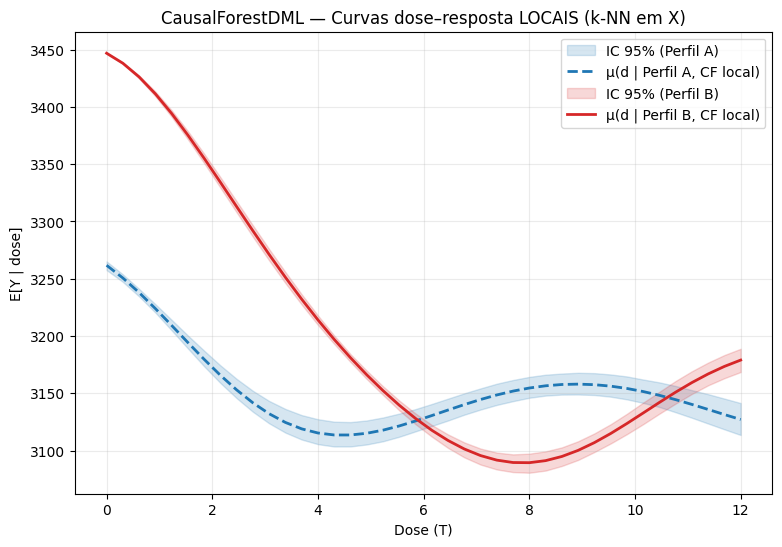

In [34]:
# ==========================================================
# CausalForestDML — Curvas dose–resposta LOCAIS (k-NN em X)
#   usa o mesmo cf/tfeat/outcome_model/Xn/T/t_grid/t0 já definidos
# ==========================================================
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

rng = np.random.default_rng(123)

# se perdeu X bruto, recupere de df_:
X_raw = df_[['casada','mage','medu']].to_numpy(dtype=np.float32)
scaler_X = StandardScaler().fit(X_raw)     # mesmo padrão do fit do CF
Xn_all = Xn                                # já padronizado no treino do CF

def cf_local_curve(x_target, k=400, B=300, alpha=0.05):
    """
    Curva dose–resposta local ao redor de x_target (k vizinhos em X),
    com IC 95% por bootstrap das unidades (sem refitar cf).
    Requer: cf, tfeat, outcome_model, Xn_all, T, t_grid, t0 já existentes.
    """
    # 1) acha k vizinhos em X padronizado
    x0n = scaler_X.transform(np.asarray(x_target, dtype=float).reshape(1, -1))
    nn = NearestNeighbors(n_neighbors=min(k, len(Xn_all)), metric='euclidean').fit(Xn_all)
    idx = nn.kneighbors(x0n, return_distance=False).ravel()
    Xloc = Xn_all[idx]
    M = len(idx)

    # 2) nível no baseline e efeitos CF por dose
    y0_hat = predict_y_at_t(Xloc, t0)  # (M,)
    G = len(t_grid)
    Eff = np.empty((G, M), dtype=np.float32)
    for g, t1 in enumerate(t_grid):
        T0 = np.full((M, 1), t0, dtype=np.float32)
        T1 = np.full((M, 1), t1, dtype=np.float32)
        Eff[g, :] = cf.effect(Xloc, T0=T0, T1=T1)

    mu_hat = (y0_hat[None, :] + Eff).mean(axis=1)

    # 3) IC via bootstrap das unidades locais
    boot_mu = np.empty((B, G), dtype=np.float32)
    for b in range(B):
        samp = rng.integers(0, M, size=M)
        boot_mu[b, :] = (y0_hat[samp][None, :] + Eff[:, samp]).mean(axis=1)

    lo = np.percentile(boot_mu, 100*(alpha/2), axis=0)
    hi = np.percentile(boot_mu, 100*(1-alpha/2), axis=0)
    return pd.DataFrame({"t": t_grid, "mu": mu_hat, "lo": lo, "hi": hi})

# ---------------- EXEMPLO: dois perfis ----------------
xA = [0, 22,  8]   # casada=0, mage=22, medu=8
xB = [1, 30, 12]   # casada=1, mage=30, medu=12

res_A = cf_local_curve(xA, k=400, B=300)
res_B = cf_local_curve(xB, k=400, B=300)

plt.figure(figsize=(9,6))
for lab, res, col, ls in [
    ("Perfil A", res_A, "#1f77b4", "--"),
    ("Perfil B", res_B, "#d62728", "-")
]:
    plt.fill_between(res["t"], res["lo"], res["hi"], color=col, alpha=0.18, label=f"IC 95% ({lab})")
    plt.plot(res["t"], res["mu"], color=col, lw=2, ls=ls, label=f"μ(d | {lab}, CF local)")
plt.xlabel("Dose (T)")
plt.ylabel("E[Y | dose]")
plt.title("CausalForestDML — Curvas dose–resposta LOCAIS (k-NN em X)")
plt.grid(True, alpha=0.25); plt.legend(); plt.show()
